In [0]:
# !pip install -U tf-nightly

In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: numpy>=1.13.3 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: tensorboard<1.8.0,>=1.7.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: absl-py>=0.1.6 in /usr/

In [2]:
import tensorflow as tf
# The TF version should be >= 1.7
print(tf.__version__)

1.7.0


In [0]:
from tensorflow import keras

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K


In [0]:
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

In [5]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Using TensorFlow backend.


60000 train samples
10000 test samples


In [6]:
num_classes = 10

model = tf.keras.Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              ?                         401920    
_________________________________________________________________
dropout_1 (Dropout)          ?                         0         
_________________________________________________________________
dense_2 (Dense)              ?                         262656    
_________________________________________________________________
dropout_2 (Dropout)          ?                         0         
_________________________________________________________________
dense_3 (Dense)              ?                         5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
BATCH_SIZE = 128
# BATCH_SIZE = 2
SHUFFLE_SIZE = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
          .shuffle(SHUFFLE_SIZE) \
          .batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
          .batch(BATCH_SIZE)

# View a single example entry from a batch
#features, labels = tfe.Iterator(test_dataset).next()
#print("example feature:", features[0])
#print("example label:", labels[0])


In [0]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)


In [0]:
optimizer = tf.train.AdamOptimizer()

In [11]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of BATCH_SIZE
  for images, labels in tfe.Iterator(train_dataset):
    # Optimize the model
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, images, labels))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(images), axis=1, output_type=tf.int32), labels)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
#  if epoch % 50 == 0:
  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
    

Epoch 000: Loss: 0.442, Accuracy: 84.222%
Epoch 001: Loss: 0.325, Accuracy: 88.082%
Epoch 002: Loss: 0.289, Accuracy: 89.507%
Epoch 003: Loss: 0.266, Accuracy: 90.145%
Epoch 004: Loss: 0.247, Accuracy: 90.817%
Epoch 005: Loss: 0.232, Accuracy: 91.285%
Epoch 006: Loss: 0.217, Accuracy: 91.880%
Epoch 007: Loss: 0.207, Accuracy: 92.220%
Epoch 008: Loss: 0.196, Accuracy: 92.712%
Epoch 009: Loss: 0.184, Accuracy: 93.113%


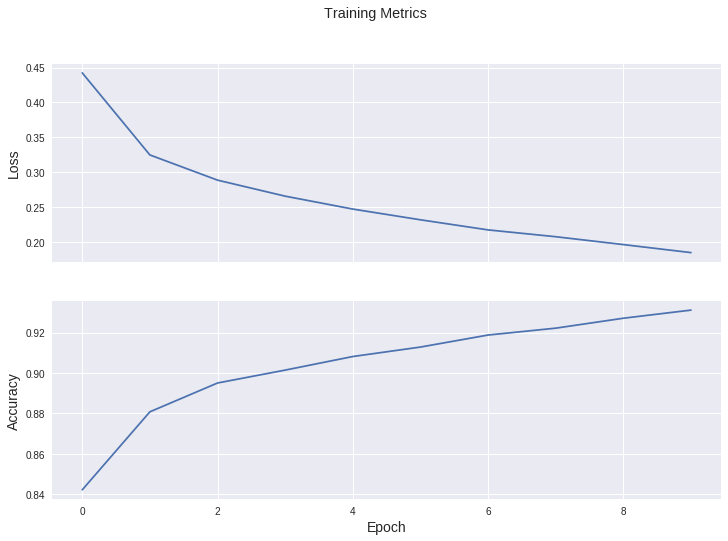

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [13]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 88.660%


<hr>
Copyright 2018 Google Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.